# Построение множества допустимых значений скорости ветра
Предполагается, что перед вылетом самолета из города N в город M, метеослужба проводит измерение продольной и боковой скорости ветра в аэропорту прилета. По этим измерениям принимается решение о вылете самолета или задержке рейса, при этом за время полета ветер может измениться.

Задача исследуется в полярных координатах. Введем обозначения

$v_0$ - скорость ветра в начальный момент времени

$\beta_0$ - направление ветра (в радианах) в начальный момент времени

$\xi$ - изменение скорости ветра по абсолютной величине

$\eta$ - изменение направления ветра (в радианах)

$w_x^{max}$ - максимально допустимая скорость попутного ветра (ну или встречного)

$w_x^{min}$ - максимально допустимая скорость встречного ветра (ну или попутного, соответственно(

$w_z^{max}$ - максимально допустимая скорость ветра в направлении поперек ВПП

Связь между начальной и конечной скоростью и направлением ветра

\begin{gather}
W_x^t = (v_0+\xi)cos(\beta_0+\eta),\\
W_z^t = (v_0+\xi)sin(\beta_0+\eta)
\end{gather}

Самолет при подлете к аэропорту назначения получит разрешение на посадку если выполнено условие
$$
|W_z^t| \le w_z^{max}, w_x^{min} \le W_x^t \le w_x^{max}
$$
Необходимо определить множество скоростей и направлений ветра в момент вылета, при которых разрешение на посадку будет получено с вероятностью не меньше заданной


## Ход решения
Сперва находим начальную точку - максимально допустимую скорость ветра, при которой будет дано разрешение на вылет, если  $\beta_0 = 0$. Далее поворачиваем вектор скорости с заданным шагом $\Delta\beta$ и находим изменение его скорости $\Delta v$, при которой вероятность останется неизменной.
$$
P(v_0, \beta_0) = P(|W_z^t| \le w_z^{max}, w_x^{min} \le W_x^t \le w_x^{max})
$$
Условие
$$
\frac{\partial}{\partial \beta_0}P(v_0, \beta_0)\Delta\beta + \frac{\partial}{\partial v_0}P(v_0, \beta_0)\Delta v = 0
$$

In [11]:
# setup
from LFlow.stochastic_model import IndependentGenerator, MultivariateGaussGenerator, stats
from LFlow.labos_flow_v2 import LabFunc, np, plt, LabSigmoid, Identity, LabArctg, LabCos, LabSin
from LFlow.labos_point import Point
np.seterr(all='ignore')

sigma_xi = 1.9
sigma_eta = 27*np.pi/180
alpha = 0.99
wz_max = 15
wx_min = -25
wx_max = 10
step = 0.005

In [12]:
sm = IndependentGenerator(['xi', 'eta'], [stats.norm(scale=sigma_xi), stats.norm(scale=sigma_eta)])
_, sample = sm.rvs(10000)

v0 = Identity('v0')
beta0 = Identity('beta0')

w0x = v0*LabCos(beta0)
w0z = v0*LabSin(beta0)
xi = Identity('xi')
eta = Identity('eta')


Wx = (v0 + xi)*LabCos(beta0 + eta)
Wz = (v0 + xi)*LabSin(beta0 + eta)

cond1 = LabSigmoid(wz_max**2 - Wz**2, theta=12)
cond2 = LabSigmoid((Wx - wx_min)*(wx_max - Wx), theta=12)
total_cond = cond1*cond2

Start point: 
{'v0': 6.18896484375, 'beta0': 0.0}
..............................................................................................................................

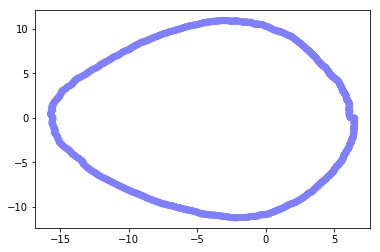

In [10]:
points = []
colors = [] #blue for points with p>alpha, else red
probs = []
"""
методом дихотомии ищем начальную точку с нулевой координатой w0z
"""
pnt1 = Point({'v0' : 0, 'beta0' : 0})
pnt2 = Point({'v0' : 30, 'beta0' : 0})
p1 = sm.papa_carlo(total_cond, pnt1, sample)
p2 = sm.papa_carlo(total_cond, pnt2, sample)
pmid = sm.papa_carlo(total_cond, 0.5*(pnt1+pnt2), sample)
while (pnt1-pnt2).norm() > 0.025:
    if pmid > alpha:
        pnt1 = 0.5*(pnt1+pnt2)
    else:
        pnt2 = 0.5*(pnt1+pnt2)
    pmid = sm.papa_carlo(total_cond, 0.5*(pnt1+pnt2), sample)
start_point = 0.5*(pnt1+pnt2)
points.append(Point({'w0x' : w0x(start_point), 'w0z' : w0z(start_point)}))
colors.append([0.5, 0.5, 1])
print('Start point: ')
print(start_point)
"""
теперь собираем точки на границе области допустимых скоростей
при построении полагаем, что должна получатся выпуклая область типа эллипса,
то есть уменьшение по модулю одной координаты должно увеличивать диапазон для другой
"""
cur_point = Point(start_point.dict.copy())
p, grad = sm.papa_carlo(total_cond, cur_point, sample, derivs = ['v0', 'beta0']) 
for i, beta0i in enumerate(np.arange(0, 2*np.pi, step)):
    probs.append(p)
    cur_point['beta0'] = beta0i
    cur_point['v0'] -= step*grad['beta0']/grad['v0']
    p, grad = sm.papa_carlo(total_cond, cur_point, sample, derivs = ['v0', 'beta0']) 
    points.append(Point({'w0x' : w0x(cur_point), 'w0z' : w0z(cur_point)}))
    if p >= alpha - 0.02*alpha:
        colors.append([0.5, 0.5, 1])
    else:
        colors.append([1, 0, 0])
    if i % 10 == 0:
        print('.', end='')

sm.visualize(points, args=['w0x', 'w0z'], colors=colors)